In [234]:
from IPython.display import Image
import requests
import pandas as pd
import plotly.express as px
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
import numpy as np

In [235]:
# Read the CSV file into a DataFrame
hourly_dataframe = pd.read_csv('/home/alfred/open-meteo-phx_weather.csv',skiprows=2)

In [236]:
print(hourly_dataframe.head())

               time  temperature_2m (°F)  rain (inch)  \
0  2023-01-01T00:00                 62.7          0.0   
1  2023-01-01T01:00                 60.2          0.0   
2  2023-01-01T02:00                 58.2          0.0   
3  2023-01-01T03:00                 56.0          0.0   
4  2023-01-01T04:00                 54.8          0.0   

   weather_code (wmo code)  cloud_cover (%)  
0                        1               35  
1                        1               30  
2                        1               30  
3                        1               30  
4                        1               30  


In [237]:
# Read the CSV file into a DataFrame
df_phx_police = pd.read_csv('/home/alfred/phx_police.csv')

In [238]:
# Display the first few rows of the DataFrame
print(df_phx_police.head())

   _id  INCIDENT_NUM DISP_CODE                             DISPOSITION  \
0    1  202300000003         N                      NO ACTION REQUIRED   
1    2  202300000004         N                      NO ACTION REQUIRED   
2    3  202300000002         O  OTHER (SUPP/FALSE ALARM/FI/LOUD PARTY)   
3    4  202300000129         N                      NO ACTION REQUIRED   
4    5  202300000024         N                      NO ACTION REQUIRED   

  FINAL_RADIO_CODE         FINAL_CALL_TYPE         CALL_RECEIVED  \
0             415P  LOUD PARTY DISTURBANCE  1/1/2023  12:00:19AM   
1             415G             SHOTS FIRED  1/1/2023  12:00:37AM   
2             459A          BURGLARY ALARM  1/1/2023  12:01:10AM   
3              239                   FIGHT  1/1/2023  12:01:16AM   
4             415G             SHOTS FIRED  1/1/2023  12:02:12AM   

    HUNDREDBLOCKADDR   GRID  
0   12XX W MONROE ST   BA26  
1     68XX N 25TH DR  CC23B  
2       9XX N 5TH ST   BB28  
3   208XX N 27TH AVE   EB2

In [239]:
# Read the CSV file into a DataFrame
df_phx_fire = pd.read_csv('/home/alfred/phx_fire.csv')

In [240]:
print(df_phx_fire.head())

   _id    INCIDENT             REPORTED               CLOSED  \
0    1  23000002.0  2023-01-01T00:00:42  2023-01-01T00:15:05   
1    2  23000010.0  2023-01-01T00:05:10  2023-01-01T00:12:24   
2    3  23000011.0  2023-01-01T00:05:49  2023-01-01T00:27:30   
3    4  23000014.0  2023-01-01T00:07:08  2023-01-01T00:22:54   
4    5  23000015.0  2023-01-01T00:08:14  2023-01-01T01:10:56   

          INCIDENT_ADDRESS NATURE_CODE              NATURE_TEXT CATEGORY  
0           198XX N 8TH PL      CKFOUT  check fire reported out     FIRE  
1    S 19TH AV/W DARREL RD        UNKF             unknown fire     FIRE  
2  148XX N BLACK CANYON AC                                           ALS  
3           41XX N 28TH AV       GRASS               grass fire     FIRE  
4           32XX N 53RD LN                                           ALS  


In [241]:
if df_phx_police is not None:
    print("phx_police:")
    print(df_phx_police.head())

phx_police:
   _id  INCIDENT_NUM DISP_CODE                             DISPOSITION  \
0    1  202300000003         N                      NO ACTION REQUIRED   
1    2  202300000004         N                      NO ACTION REQUIRED   
2    3  202300000002         O  OTHER (SUPP/FALSE ALARM/FI/LOUD PARTY)   
3    4  202300000129         N                      NO ACTION REQUIRED   
4    5  202300000024         N                      NO ACTION REQUIRED   

  FINAL_RADIO_CODE         FINAL_CALL_TYPE         CALL_RECEIVED  \
0             415P  LOUD PARTY DISTURBANCE  1/1/2023  12:00:19AM   
1             415G             SHOTS FIRED  1/1/2023  12:00:37AM   
2             459A          BURGLARY ALARM  1/1/2023  12:01:10AM   
3              239                   FIGHT  1/1/2023  12:01:16AM   
4             415G             SHOTS FIRED  1/1/2023  12:02:12AM   

    HUNDREDBLOCKADDR   GRID  
0   12XX W MONROE ST   BA26  
1     68XX N 25TH DR  CC23B  
2       9XX N 5TH ST   BB28  
3   208XX N 27

In [242]:
if df_phx_fire is not None:
    print("phx_fire:")
    print(df_phx_fire.head())

phx_fire:
   _id    INCIDENT             REPORTED               CLOSED  \
0    1  23000002.0  2023-01-01T00:00:42  2023-01-01T00:15:05   
1    2  23000010.0  2023-01-01T00:05:10  2023-01-01T00:12:24   
2    3  23000011.0  2023-01-01T00:05:49  2023-01-01T00:27:30   
3    4  23000014.0  2023-01-01T00:07:08  2023-01-01T00:22:54   
4    5  23000015.0  2023-01-01T00:08:14  2023-01-01T01:10:56   

          INCIDENT_ADDRESS NATURE_CODE              NATURE_TEXT CATEGORY  
0           198XX N 8TH PL      CKFOUT  check fire reported out     FIRE  
1    S 19TH AV/W DARREL RD        UNKF             unknown fire     FIRE  
2  148XX N BLACK CANYON AC                                           ALS  
3           41XX N 28TH AV       GRASS               grass fire     FIRE  
4           32XX N 53RD LN                                           ALS  


In [243]:
hourly_dataframe['time'] = pd.to_datetime(hourly_dataframe['time'], format='%Y-%m-%dT%H:%M')
df_phx_police['CALL_RECEIVED'] = pd.to_datetime(df_phx_police['CALL_RECEIVED'], format='%m/%d/%Y %I:%M:%S%p')
df_phx_fire['CLOSED'] = pd.to_datetime(df_phx_fire['CLOSED'], format='%Y-%m-%dT%H:%M:%S')
df_phx_fire['REPORTED'] = pd.to_datetime(df_phx_fire['REPORTED'], format='%Y-%m-%dT%H:%M:%S')

In [244]:
hourly_dataframe['time'] = hourly_dataframe['time'].dt.tz_localize(None)
df_phx_police['CALL_RECEIVED'] = df_phx_police['CALL_RECEIVED'].dt.tz_localize(None)
df_phx_fire['REPORTED'] = df_phx_fire['REPORTED'].dt.tz_localize(None)
df_phx_fire['CLOSED'] = df_phx_fire['CLOSED'].dt.tz_localize(None)

In [245]:
print(hourly_dataframe['time'].head())
print(df_phx_police['CALL_RECEIVED'].head())
print(df_phx_fire['REPORTED'].head())
print(df_phx_fire['CLOSED'].head())

0   2023-01-01 00:00:00
1   2023-01-01 01:00:00
2   2023-01-01 02:00:00
3   2023-01-01 03:00:00
4   2023-01-01 04:00:00
Name: time, dtype: datetime64[ns]
0   2023-01-01 00:00:19
1   2023-01-01 00:00:37
2   2023-01-01 00:01:10
3   2023-01-01 00:01:16
4   2023-01-01 00:02:12
Name: CALL_RECEIVED, dtype: datetime64[ns]
0   2023-01-01 00:00:42
1   2023-01-01 00:05:10
2   2023-01-01 00:05:49
3   2023-01-01 00:07:08
4   2023-01-01 00:08:14
Name: REPORTED, dtype: datetime64[ns]
0   2023-01-01 00:15:05
1   2023-01-01 00:12:24
2   2023-01-01 00:27:30
3   2023-01-01 00:22:54
4   2023-01-01 01:10:56
Name: CLOSED, dtype: datetime64[ns]


In [246]:
# Rename the column in the DataFrame
hourly_dataframe.rename(columns={'time': 'date'}, inplace=True)
hourly_dataframe.rename(columns={'temperature_2m (°F)': 'temperature'}, inplace=True)
hourly_dataframe.rename(columns={'rain (inch)': 'rain'}, inplace=True)
hourly_dataframe.rename(columns={'weather_code (wmo code)': 'weather_code'}, inplace=True)
hourly_dataframe.rename(columns={'cloud_cover (%)': 'cloud_cover'}, inplace=True)
# Drop duplicates based on the 'date' column
#hourly_dataframe.drop_duplicates(subset=['date'], keep='last', inplace=True)



In [247]:
print(df_phx_police.columns.tolist())


['_id', 'INCIDENT_NUM', 'DISP_CODE', 'DISPOSITION', 'FINAL_RADIO_CODE', 'FINAL_CALL_TYPE', 'CALL_RECEIVED', 'HUNDREDBLOCKADDR', 'GRID']


In [248]:
df_phx_police.columns = df_phx_police.columns.str.strip()
print(df_phx_police.columns.tolist())


['_id', 'INCIDENT_NUM', 'DISP_CODE', 'DISPOSITION', 'FINAL_RADIO_CODE', 'FINAL_CALL_TYPE', 'CALL_RECEIVED', 'HUNDREDBLOCKADDR', 'GRID']


In [249]:
print(df_phx_fire.columns.tolist())

['_id', 'INCIDENT', 'REPORTED', 'CLOSED', 'INCIDENT_ADDRESS', 'NATURE_CODE', 'NATURE_TEXT', 'CATEGORY']


In [250]:
df_phx_fire.columns = df_phx_fire.columns.str.strip()
print(df_phx_fire.columns.tolist())

['_id', 'INCIDENT', 'REPORTED', 'CLOSED', 'INCIDENT_ADDRESS', 'NATURE_CODE', 'NATURE_TEXT', 'CATEGORY']


In [251]:

df_phx_police.drop(columns=['_id'], inplace=True)
#df_phx_police.drop(columns=['_full_text'], inplace=True)
print(df_phx_police.columns.tolist())

['INCIDENT_NUM', 'DISP_CODE', 'DISPOSITION', 'FINAL_RADIO_CODE', 'FINAL_CALL_TYPE', 'CALL_RECEIVED', 'HUNDREDBLOCKADDR', 'GRID']


In [252]:
#df_phx_police.drop(columns=['_id'], inplace=True)
df_phx_police.rename(columns={
    'INCIDENT_NUM': 'incident_num',
    'DISP_CODE': 'disp_code',
    'DISPOSITION': 'disposition',
    'FINAL_RADIO_CODE': 'final_radio_code',
    'FINAL_CALL_TYPE': 'final_call_type',
    'CALL_RECEIVED': 'call_received',
    'HUNDREDBLOCKADDR': 'hundredblockaddr',
    'GRID': 'grid'
}, inplace=True)


In [253]:
def get_password_from_csv(filepath, key_type):
    df = pd.read_csv('/home/alfred/Documents/projects/api_keys - Sheet1.csv')
    password = df.loc[df['type'] == key_type, 'keys'].values[0]
    return password

# Get the password from the CSV file
password = get_password_from_csv('/path/to/keys.csv', 'database')

# Construct the database connection string
username = 'postgres'
host = 'localhost'
port = '5432'
database = 'postgres'
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}/{database}'
engine = create_engine(connection_string)

In [254]:
# Establish a connection
with engine.connect() as connection:
    # Begin a transaction
    with connection.begin():
        # Execute DELETE statements for multiple tables
        connection.execute(text("DELETE FROM phx_police"))
        connection.execute(text("DELETE FROM phx_fire"))
        connection.execute(text("DELETE FROM weather"))

In [255]:
df_phx_police.to_sql('phx_police', con=engine, index=False, if_exists='append')
df_phx_fire.to_sql('phx_fire', con=engine, index=False, if_exists='append')
hourly_dataframe.to_sql('weather', con=engine, index=False, if_exists='append')

760

In [256]:
# Create temporary columns with truncated date
df_phx_police['call_received_hour'] = df_phx_police['call_received'].dt.floor('h')
hourly_dataframe['date_hour'] = hourly_dataframe['date'].dt.floor('h')

# Perform the left join
df_merged = pd.merge(df_phx_police, hourly_dataframe, how='left', left_on='call_received_hour', right_on='date_hour')

# Select the desired columns and drop temporary columns
df_phx_weather_police = df_merged[['incident_num', 'disposition', 'final_call_type', 'call_received', 'temperature', 'rain', 'weather_code', 'cloud_cover']]

In [257]:
print(df_phx_weather_police.head()) 

   incident_num                             disposition  \
0  202300000003                      NO ACTION REQUIRED   
1  202300000004                      NO ACTION REQUIRED   
2  202300000002  OTHER (SUPP/FALSE ALARM/FI/LOUD PARTY)   
3  202300000129                      NO ACTION REQUIRED   
4  202300000024                      NO ACTION REQUIRED   

          final_call_type       call_received  temperature  rain  \
0  LOUD PARTY DISTURBANCE 2023-01-01 00:00:19         62.7   0.0   
1             SHOTS FIRED 2023-01-01 00:00:37         62.7   0.0   
2          BURGLARY ALARM 2023-01-01 00:01:10         62.7   0.0   
3                   FIGHT 2023-01-01 00:01:16         62.7   0.0   
4             SHOTS FIRED 2023-01-01 00:02:12         62.7   0.0   

   weather_code  cloud_cover  
0             1           35  
1             1           35  
2             1           35  
3             1           35  
4             1           35  


In [258]:
weather_police_grouped = df_merged.groupby(['final_call_type', 'call_received_hour']).agg({
    'incident_num': 'count',
    'temperature': 'mean',
    'rain': 'mean'
}).reset_index()

print(weather_police_grouped.describe())

                  call_received_hour   incident_num    temperature  \
count                         258511  258511.000000  258511.000000   
mean   2023-07-02 08:16:04.661465600       2.249382      73.597015   
min              2023-01-01 00:00:00       1.000000      31.800000   
25%              2023-04-02 13:00:00       1.000000      57.400000   
50%              2023-07-02 08:00:00       1.000000      73.800000   
75%              2023-10-01 06:00:00       3.000000      89.300000   
max              2023-12-31 23:00:00      64.000000     116.500000   
std                              NaN       2.229629      19.278405   

                rain  
count  258511.000000  
mean        0.001177  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         0.386000  
std         0.011628  


In [259]:
# Group by final_call_type and calculate the mean temperature and total rain
weather_police_grouped = df_phx_weather_police.groupby('final_call_type').agg({
    'incident_num': 'count',  # Count the number of incidents
    'temperature': 'mean',
    'rain': 'mean'
}).reset_index()

print(weather_police_grouped)

                    final_call_type  incident_num  temperature      rain
0                9-1-1 HANG-UP CALL          3920    71.223112  0.001780
1               911 HU CLEARED CALL             8    71.237500  0.000000
2                 ABANDONED VEHICLE          9509    69.393858  0.001264
3      ABANDONED VEHICLE SUPPLEMENT            21    72.690476  0.000000
4    ABS/NEG OF VULNERABLE ADULT DV            27    70.496296  0.003370
..                              ...           ...          ...       ...
339    URINATE IN PUBLIC SUPPLEMENT             1    39.900000  0.000000
340             URINATING IN PUBLIC           250    70.033200  0.002084
341                    VEHICLE STOP            22    81.240909  0.000000
342                    WAGON WANTED           786    71.836387  0.000817
343         WEAPON MISUSE/VIOLATION           358    74.080168  0.001883

[344 rows x 4 columns]


In [260]:
def mode(series):
    m = stats.mode(series, nan_policy='omit')
    if isinstance(m.count, np.ndarray):
        if len(m.count) > 0 and m.count[0] > 0:
            return m.mode[0]
    elif m.count > 0:
        return m.mode
    return None

# Overall summary statistics for each call type
summary_stats = df_merged.groupby('final_call_type').agg({
    'incident_num': 'count',
    'temperature': ['mean', 'std', 'min', 'max'],
    'rain': ['mean', 'std', 'min', 'max'],
    'weather_code': mode,
    'cloud_cover': 'mean'
}).reset_index()

# Sort by 'incident_num' count and limit to top 20
summary_stats = summary_stats.sort_values(('incident_num', 'count'), ascending=False).head(20)

# Flatten the multi-level column index
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

print(summary_stats)


                   final_call_type_  incident_num_count  temperature_mean  \
331                     TRESPASSING               62168         72.498945   
59                    CHECK WELFARE               50351         74.087524   
302               SUSPICIOUS PERSON               48743         73.109655   
108                           FIGHT               36784         74.809703   
44                   BURGLARY ALARM               33750         76.645132   
12             ACCIDENT NO INJURIES               28590         70.503501   
93                DOMESTIC VIOLENCE               21554         77.052969   
307                           THEFT               15159         71.251831   
29                          ASSAULT               14408         74.498556   
77                  CRIMINAL DAMAGE               13685         73.624764   
303    SUSPICIOUS PERSON IN VEHICLE               13612         74.760013   
70             CIVIL MATTER/STANDBY               13290         70.788631   

In [261]:
# Summary statistics over time
time_summary_stats = df_merged.groupby('call_received_hour').agg({
    'incident_num': 'count',
    'temperature': 'mean',
    'rain': 'mean'
}).reset_index()

print(time_summary_stats)

      call_received_hour  incident_num  temperature  rain
0    2023-01-01 00:00:00            97         62.7   0.0
1    2023-01-01 01:00:00            52         60.2   0.0
2    2023-01-01 02:00:00            60         58.2   0.0
3    2023-01-01 03:00:00            36         56.0   0.0
4    2023-01-01 04:00:00            50         54.8   0.0
...                  ...           ...          ...   ...
8755 2023-12-31 19:00:00            89         57.3   0.0
8756 2023-12-31 20:00:00            63         59.5   0.0
8757 2023-12-31 21:00:00            68         60.8   0.0
8758 2023-12-31 22:00:00            68         61.4   0.0
8759 2023-12-31 23:00:00            69         60.9   0.0

[8760 rows x 4 columns]


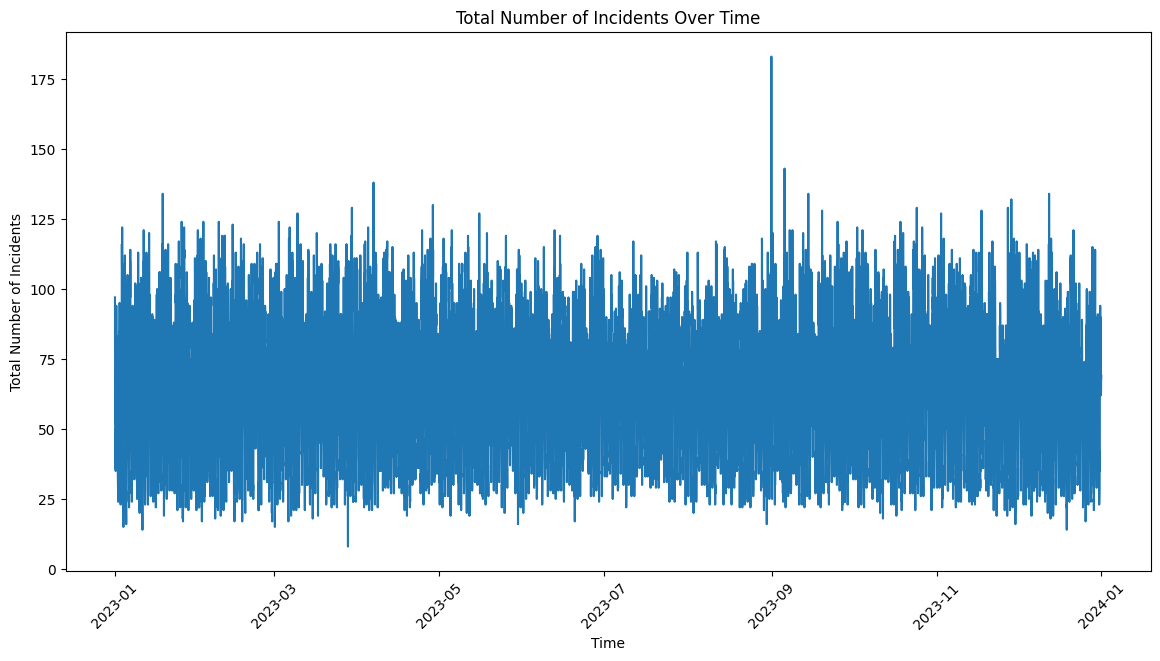

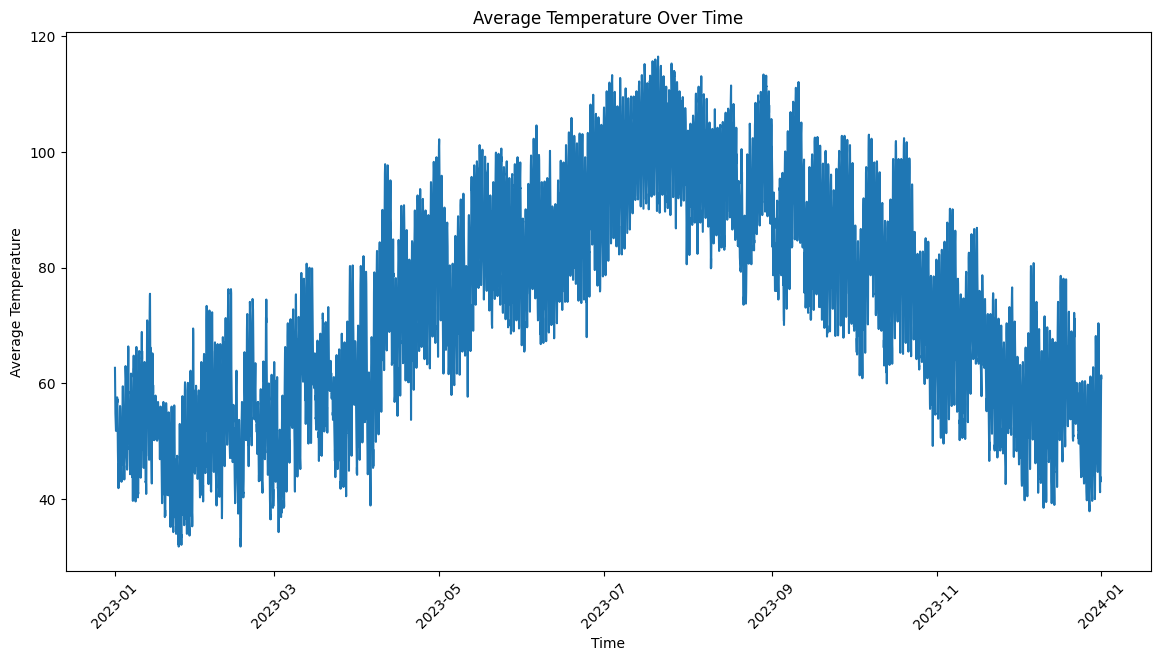

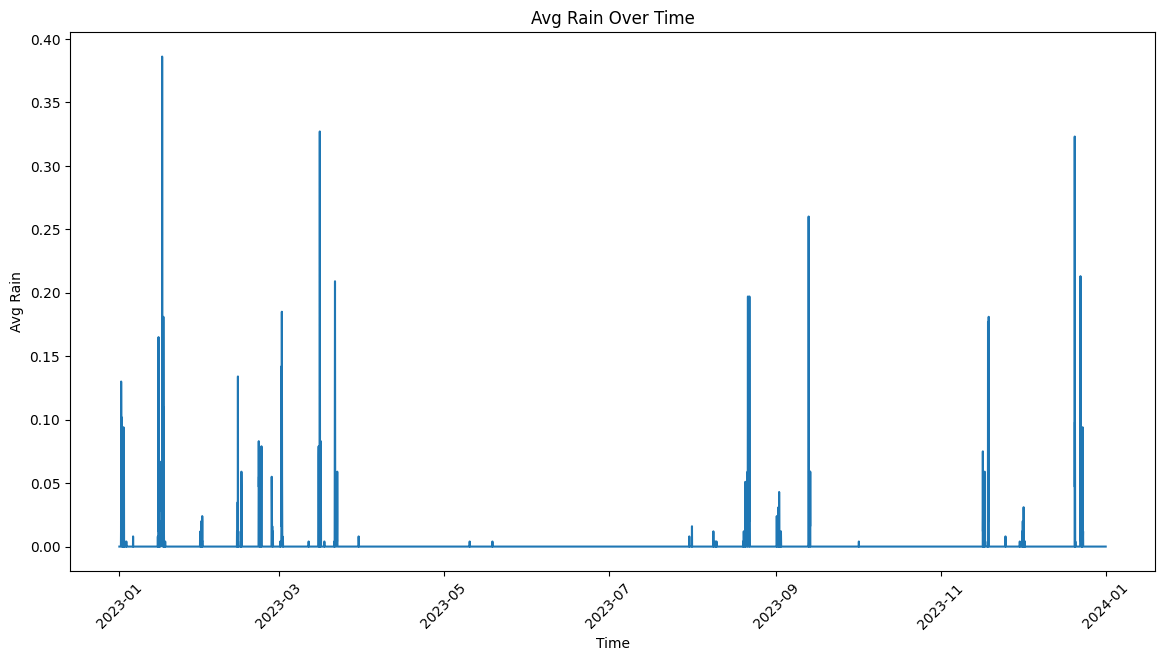

In [262]:
# Visualize summaries
plt.figure(figsize=(14, 7))
sns.lineplot(data=time_summary_stats, x='call_received_hour', y='incident_num')
plt.xlabel('Time')
plt.ylabel('Total Number of Incidents')
plt.title('Total Number of Incidents Over Time')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=time_summary_stats, x='call_received_hour', y='temperature')
plt.xlabel('Time')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Over Time')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=time_summary_stats, x='call_received_hour', y='rain')
plt.xlabel('Time')
plt.ylabel('Avg Rain')
plt.title('Avg Rain Over Time')
plt.xticks(rotation=45)
plt.show()

In [263]:
# Summary reports
incident_summary_report = df_merged.groupby('final_call_type')['incident_num'].count().reset_index().rename(columns={'incident_num': 'total_incidents'})
print(incident_summary_report)

weather_summary_report = df_merged.groupby('final_call_type').agg({
    'temperature': 'mean',
    'rain': 'sum'
}).reset_index().rename(columns={'temperature': 'average_temperature', 'rain': 'total_rain'})
print(weather_summary_report)

                    final_call_type  total_incidents
0                9-1-1 HANG-UP CALL             3920
1               911 HU CLEARED CALL                8
2                 ABANDONED VEHICLE             9509
3      ABANDONED VEHICLE SUPPLEMENT               21
4    ABS/NEG OF VULNERABLE ADULT DV               27
..                              ...              ...
339    URINATE IN PUBLIC SUPPLEMENT                1
340             URINATING IN PUBLIC              250
341                    VEHICLE STOP               22
342                    WAGON WANTED              786
343         WEAPON MISUSE/VIOLATION              358

[344 rows x 2 columns]
                    final_call_type  average_temperature  total_rain
0                9-1-1 HANG-UP CALL            71.223112       6.978
1               911 HU CLEARED CALL            71.237500       0.000
2                 ABANDONED VEHICLE            69.393858      12.020
3      ABANDONED VEHICLE SUPPLEMENT            72.690476       0

In [264]:
# Statistical tests
corr_temp, _ = pearsonr(df_merged['temperature'], df_merged['incident_num'])
print(f'Correlation between temperature and number of incidents: {corr_temp}')

corr_rain, _ = pearsonr(df_merged['rain'], df_merged['incident_num'])
print(f'Correlation between rain and number of incidents: {corr_rain}')

Correlation between temperature and number of incidents: 0.28819677586823544
Correlation between rain and number of incidents: -0.03291363914111975


In [265]:
# Create temporary columns with truncated date
df_phx_fire['REPORTED_HOUR'] = df_phx_fire['REPORTED'].dt.floor('h')
hourly_dataframe['date_hour'] = hourly_dataframe['date'].dt.floor('h')

# Perform the left join
df_merged = pd.merge(df_phx_fire, hourly_dataframe, how='left', left_on='REPORTED_HOUR', right_on='date_hour')

# Select the desired columns and drop temporary columns
df_phx_weather_fire = df_merged[['INCIDENT', 'CATEGORY', 'REPORTED', 'temperature', 'rain', 'weather_code', 'cloud_cover']]

In [266]:
df_phx_weather_fire['REPORTED_HOUR'] = df_phx_weather_fire['REPORTED'].dt.floor('h')
incident_counts_per_hour = df_phx_weather_fire.groupby(['REPORTED_HOUR', 'CATEGORY']).size().reset_index(name='incident_count')

# Merge with weather data on hourly basis
hourly_weather = df_phx_weather_fire[['REPORTED_HOUR', 'temperature', 'rain', 'weather_code', 'cloud_cover']].drop_duplicates()
merged_data = pd.merge(incident_counts_per_hour, hourly_weather, on='REPORTED_HOUR', how='left')

# Correlations
numeric_columns = ['incident_count', 'temperature', 'rain', 'cloud_cover']
correlation_matrix = merged_data[numeric_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                incident_count  temperature      rain  cloud_cover
incident_count        1.000000    -0.024416 -0.002295    -0.008092
temperature          -0.024416     1.000000 -0.078942    -0.189286
rain                 -0.002295    -0.078942  1.000000     0.280161
cloud_cover          -0.008092    -0.189286  0.280161     1.000000


/tmp/ipykernel_62468/2268882616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phx_weather_fire['REPORTED_HOUR'] = df_phx_weather_fire['REPORTED'].dt.floor('h')


In [267]:
for column in ['temperature', 'rain', 'cloud_cover']:
    correlation, p_value = pearsonr(merged_data['incident_count'], merged_data[column])
    print(f"Correlation between incident count and {column}: {correlation} (p-value: {p_value})")

Correlation between incident count and temperature: -0.02441625817505977 (p-value: 1.1902091478963394e-05)
Correlation between incident count and rain: -0.0022953898149085383 (p-value: 0.6805980273377065)
Correlation between incident count and cloud_cover: -0.008091992049592187 (p-value: 0.1467209814091657)


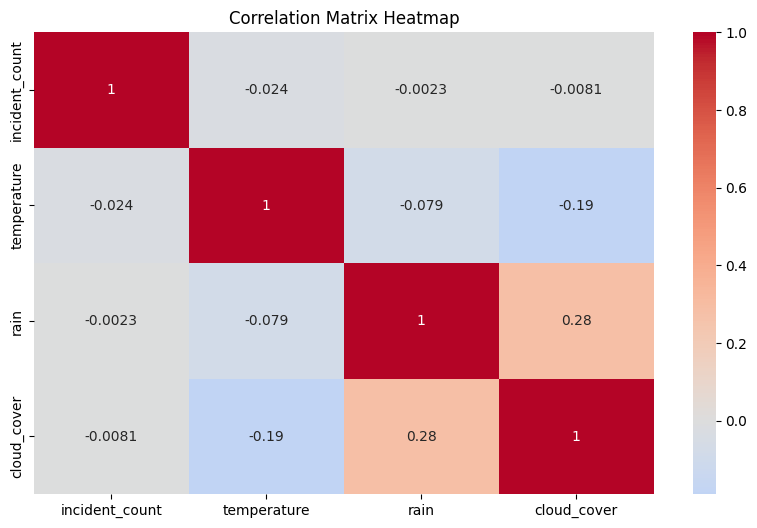

In [268]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()
